In [2]:
#in the code below , i build score card based on log-reg model
#Syzdykayev Makhmut

In [1]:
import pandas as pd
import numpy as np
import scorecardpy as sc

%pylab inline
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import statsmodels.api as sm

import lightgbm
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier, plot_importance

import pickle
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from matplotlib import rc
rc('font', family = 'Verdana')

Populating the interactive namespace from numpy and matplotlib


/Users/a1/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)
/Users/a1/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/a1/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/a1/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full 

In [2]:
data = pd.read_excel('data_set_excel.xlsx')
print(data.shape)
for column_name in data.columns:
    print(column_name, ' - ', data[column_name].dtype)

(30000, 25)
ID  -  int64
LIMIT_BAL  -  int64
SEX  -  object
EDUCATION  -  object
MARRIAGE  -  object
AGE  -  int64
PAY_0  -  int64
PAY_2  -  int64
PAY_3  -  int64
PAY_4  -  int64
PAY_5  -  int64
PAY_6  -  int64
BILL_AMT1  -  int64
BILL_AMT2  -  int64
BILL_AMT3  -  int64
BILL_AMT4  -  int64
BILL_AMT5  -  int64
BILL_AMT6  -  int64
PAY_AMT1  -  int64
PAY_AMT2  -  int64
PAY_AMT3  -  int64
PAY_AMT4  -  int64
PAY_AMT5  -  int64
PAY_AMT6  -  int64
target  -  int64


In [3]:
data.drop(columns = ['ID'], inplace = True)

In [4]:
data.fillna(-9999, inplace=True)

In [5]:
text_features = [col for col in data.columns if data[col].dtype == 'object']
text_data = pd.get_dummies(data[text_features], prefix = text_features, drop_first = True)

numeric_features = [col for col in data.columns if data[col].dtype != 'object']
data_numeric = pd.concat([data[numeric_features], text_data], axis = 1)

print(data.shape, data_numeric.shape)
data.head(5)

(30000, 24) (30000, 31)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,20000,female,bachelor,married,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,female,bachelor,single,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,female,bachelor,single,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,female,bachelor,married,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,male,bachelor,married,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
data_numeric

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,SEX_male,EDUCATION_bachelor,EDUCATION_college,EDUCATION_doctoral studies,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_magistracy,MARRIAGE_divorced,MARRIAGE_married,MARRIAGE_single
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,1,0,0,0,0,0,0,1,0
1,120000,26,-1,2,0,0,0,2,2682,1725,...,0,1,0,0,0,0,0,0,0,1
2,90000,34,0,0,0,0,0,0,29239,14027,...,0,1,0,0,0,0,0,0,0,1
3,50000,37,0,0,0,0,0,0,46990,48233,...,0,1,0,0,0,0,0,0,1,0
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,39,0,0,0,0,0,0,188948,192815,...,1,0,0,0,0,1,0,0,1,0
29996,150000,43,-1,-1,-1,-1,0,0,1683,1828,...,1,0,0,0,0,1,0,0,0,1
29997,30000,37,4,3,2,-1,0,0,3565,3356,...,1,1,0,0,0,0,0,0,0,1
29998,80000,41,1,-1,0,0,0,-1,-1645,78379,...,1,0,0,0,0,1,0,0,1,0


In [7]:
from sklearn.metrics import roc_auc_score

In [8]:
from sklearn.model_selection import StratifiedKFold

In [9]:
def individual_gini(v):
    if data[v].dtypes == 'O':
        x = pd.get_dummies(data[v]).values
        obvious_gini = 0
    else:
        x = data[v].values.reshape(-1, 1)
        obvious_gini = abs(roc_auc_score(data.target.values,x)*2-1)
    
    parameters = {'min_weight_fraction_leaf':[0.01, 0.025, 0.05, 0.1]}
    dt = DecisionTreeClassifier(random_state=123)
    kfolds = StratifiedKFold(4)
    clf = GridSearchCV(dt, parameters, cv=kfolds.split(x, data.target.values), scoring='roc_auc')
    clf.fit(x, data.target.values)
    true_gini = abs(clf.best_score_*2-1)
    return max(obvious_gini, true_gini)

In [10]:
df_vars_ginis = pd.DataFrame(data = data.columns.values, columns = ['vars'])
df_vars_ginis['gini'] = df_vars_ginis['vars'].apply(individual_gini)

print(df_vars_ginis)

         vars      gini
0   LIMIT_BAL  0.236761
1         SEX  0.047092
2   EDUCATION  0.080282
3    MARRIAGE  0.037808
4         AGE  0.066473
5       PAY_0  0.421178
6       PAY_2  0.297225
7       PAY_3  0.266843
8       PAY_4  0.238613
9       PAY_5  0.218534
10      PAY_6  0.203236
11  BILL_AMT1  0.059442
12  BILL_AMT2  0.050444
13  BILL_AMT3  0.050912
14  BILL_AMT4  0.050309
15  BILL_AMT5  0.072859
16  BILL_AMT6  0.064760
17   PAY_AMT1  0.225657
18   PAY_AMT2  0.210601
19   PAY_AMT3  0.193110
20   PAY_AMT4  0.181013
21   PAY_AMT5  0.161249
22   PAY_AMT6  0.169705
23     target  1.000000


In [11]:
categorical_vars = []
numeric_vars = []

for col in data.columns:
    if data[col].nunique() < 4 or data[col].dtypes == 'O':
        categorical_vars.append(col)
    else:
        numeric_vars.append(col)

In [12]:
print('categorical: ', categorical_vars)
print(' ')
print('numerical: ', numeric_vars)

categorical:  ['SEX', 'EDUCATION', 'MARRIAGE', 'target']
 
numerical:  ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [13]:
from scipy import stats

In [14]:
sample_size = data.shape[0]

def cramers_v(col1, col2):
    confusion_matrix = pd.crosstab(data[col1], data[col2])
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    
    if(sample_size * (min(confusion_matrix.shape)-1) != 0):
        return np.sqrt(chi2/(sample_size * (min(confusion_matrix.shape)-1)))
    else:
        return 0

In [15]:
df_dat_corrs = pd.DataFrame(columns = ['var1', 'var2'])

counter = 0
for idx, col1 in enumerate(categorical_vars):
    for col2 in categorical_vars[idx+1:]:
        df_dat_corrs.loc[counter] = [col1, col2]
        counter += 1
df_dat_corrs['corr'] = df_dat_corrs.apply(lambda row: cramers_v(row['var1'], row['var2']), axis = 1)
df_dat_corrs

,var1,var2,corr
0,SEX,EDUCATION,0.032043
1,SEX,MARRIAGE,0.033171
2,SEX,target,0.039878
3,EDUCATION,MARRIAGE,0.114873
4,EDUCATION,target,0.073760
5,MARRIAGE,target,0.034478


In [16]:
df_dat_corrs.sort_values(by = ['corr'], ascending = False, inplace = True)
df_dat_corrs

,var1,var2,corr
3,EDUCATION,MARRIAGE,0.114873
4,EDUCATION,target,0.073760
2,SEX,target,0.039878
5,MARRIAGE,target,0.034478
1,SEX,MARRIAGE,0.033171
0,SEX,EDUCATION,0.032043


In [17]:
to_drop_cat = []
log = []
for i in df_dat_corrs[df_dat_corrs['corr'] > 0.7]:
    v1 = i[0]
    v2 = i[1]
    
    if v1 in to_drop_cat or v2 in to_drop_cat or v1 not in data.columns.values or v2 not in data.columns.values:
        continue
        
    if df_vars_ginis[df_vars_ginis['vars'] == v1].gini.values > df_vars_ginis[df_vars_ginis['vars'] == v2].gini.values:
        var_to_drop = v2
    else:
        var_to_drop = v1
        
    var_to_leave = v2 if(v1 == var_to_drop) else v1
    
    log.append([var_to_drop, var_to_leave, i[2]])
    to_drop_cat.append(var_to_drop)

print(len(to_drop_cat), 'variables dropped')
variables2 = [i for i in categorical_vars if i not in to_drop_cat]
print(len(variables2), 'variables left')

0 variables dropped
4 variables left


In [18]:
df_numeric = data[numeric_vars]
df_numeric.replace(-9999, NaN, inplace = True)
df_numeric.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0
1,120000,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [19]:
##%%time
df_num_corrs = df_numeric.corr()


In [20]:
np.triu(np.ones(5), k=1)

array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]])

(20, 20)


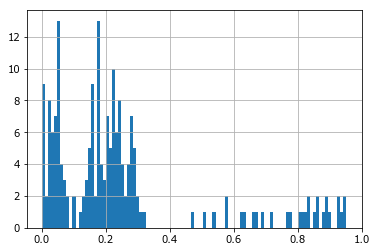

In [21]:
df_num_corrs = df_num_corrs.abs()
print(df_num_corrs.shape)

correlations = df_num_corrs.where(
    np.triu(np.ones(df_num_corrs.shape), k=1).astype(np.bool)).stack().sort_values(ascending = False)

correlations.hist(bins = 100)

In [22]:
to_drop_num = []
log = []
for i in correlations[correlations > 0.7].index:
    v1 = i[0]
    v2 = i[1]
    
    if v1 in to_drop_num or v2 in to_drop_num:
        continue
        
    if df_vars_ginis[df_vars_ginis['vars'] == v1].gini.values > df_vars_ginis[df_vars_ginis['vars'] == v2].gini.values:
        var_to_drop = v2
    else:
        var_to_drop = v1
        
    var_to_leave = v2 if(v1 == var_to_drop) else v1
    
    log.append([var_to_drop, var_to_leave, correlations[i]])
    to_drop_num.append(var_to_drop)

print(len(to_drop_num), 'variables dropped')
variables2 = [i for i in numeric_vars if i not in to_drop_num]
print(len(variables2), 'variables left')

8 variables dropped
12 variables left


In [23]:
data.drop(to_drop_cat, axis = 1, inplace = True)
data.drop(to_drop_num, axis = 1, inplace = True)
print(data.shape)

(30000, 16)


In [24]:
categorical_vars1 = []
numeric_vars1 = []

for col in data.columns:
    if data[col].nunique() < 4 or data[col].dtypes == 'O':
        categorical_vars1.append(col)
    else:
        numeric_vars1.append(col)
        
print('categorical: ', categorical_vars1, '\n')
print('numerical: ', numeric_vars1)


categorical:  ['SEX', 'EDUCATION', 'MARRIAGE', 'target'] 

numerical:  ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_6', 'BILL_AMT5', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [25]:
dt_s =sc.var_filter(data[categorical_vars1], y = 'target')
dt_s.replace(-9999, NaN, inplace = True)
#dt_s.replace(NaN, '-9999', inplace = True)
print(dt_s)

[INFO] filtering variables ...
         EDUCATION  target
0         bachelor       1
1         bachelor       1
2         bachelor       0
3         bachelor       0
4         bachelor       0
...            ...     ...
29995  high school       0
29996  high school       0
29997     bachelor       1
29998  high school       1
29999     bachelor       1

[30000 rows x 2 columns]


In [26]:
bins = sc.woebin(dt_s, y='target', x=['EDUCATION'])
#breaks_adj = sc.woebin_adj(dt_s, 'target', bins)

[INFO] creating woe binning ...


In [27]:
dt_s['EDUCATION'].unique()

array(['bachelor', 'graduate school', 'high school', 'magistracy',
       'college', 'doctoral studies', nan], dtype=object)

In [28]:
dt_s['target'].unique()

array([1, 0])

In [29]:
bins

{'EDUCATION':     variable                                                bin  count  \
 0  EDUCATION                                            missing     14   
 1  EDUCATION  college%,%magistracy%,%doctoral studies%,%grad...  11039   
 2  EDUCATION                                           bachelor  14030   
 3  EDUCATION                                        high school   4917   
 
    count_distr   good   bad   badprob       woe    bin_iv  total_iv  \
 0     0.000467     14     0  0.000000 -1.485866  0.000689  0.024578   
 1     0.367967   8970  2069  0.187426 -0.208269  0.015033  0.024578   
 2     0.467667  10700  3330  0.237349  0.091280  0.003995  0.024578   
 3     0.163900   3680  1237  0.251576  0.168328  0.004860  0.024578   
 
                                               breaks  is_special_values  
 0                                            missing               True  
 1  college%,%magistracy%,%doctoral studies%,%grad...              False  
 2                     

In [30]:
dt_s_woe = sc.woebin_ply(dt_s, bins)
dt_s_woe.drop(columns=['target'], inplace = True)

[INFO] converting into woe values ...


In [31]:
data2=pd.concat([data, dt_s_woe], axis = 1)
data2.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_6,BILL_AMT5,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target,EDUCATION_woe
0,20000,female,bachelor,married,24,2,2,-2,0,0,689,0,0,0,0,1,0.09128
1,120000,female,bachelor,single,26,-1,2,2,3455,0,1000,1000,1000,0,2000,1,0.09128
2,90000,female,bachelor,single,34,0,0,0,14948,1518,1500,1000,1000,1000,5000,0,0.09128
3,50000,female,bachelor,married,37,0,0,0,28959,2000,2019,1200,1100,1069,1000,0,0.09128
4,50000,male,bachelor,married,57,-1,0,0,19146,2000,36681,10000,9000,689,679,0,0.09128


In [32]:
list(data2.columns)

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_6',
 'BILL_AMT5',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'target',
 'EDUCATION_woe']

In [33]:
data2['EDUCATION_woe'].unique()

array([ 0.09127995, -0.20826889,  0.16832773, -1.48586646])

In [34]:
data2.drop(columns=['MARRIAGE', 'SEX'], inplace = True)

In [35]:
data2.drop(columns=['EDUCATION'], inplace = True)

In [36]:
all_x_variables = data2.columns.difference(['target']).tolist()
X = data2[all_x_variables]
y = data2['target']

In [37]:
print([i for i in data2 if i!='target'])

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    #stratify = y,
                                                   random_state = 2,
                                                   test_size = 0.25)

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())

['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_6', 'BILL_AMT5', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'EDUCATION_woe']
(22500, 13) (7500, 13)
0.2212 0.2212


In [38]:
X.columns

Index(['AGE', 'BILL_AMT5', 'EDUCATION_woe', 'LIMIT_BAL', 'PAY_0', 'PAY_2',
       'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6'],
      dtype='object')

In [39]:
def score(params):
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    XGB = XGBClassifier(**params)
    XGB.fit(X_train[X.columns], y_train)
    tr_loss = 1-roc_auc_score(y_train, XGB.predict_proba(X_train[X.columns])[:,1])*2
    te_loss = 1-roc_auc_score(y_test, XGB.predict_proba(X_test[X.columns])[:,1])*2
    return{'loss':te_loss, 'status':STATUS_OK, 'tr_loss':tr_loss}

short_trials_xgb = Trials()
space = {
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.1, 0.005),
    'max_depth' : hp.quniform('max_depth', 2, 3, 1),
    'n_estimators' : hp.choice('n_estimators', range(100, 301)),
    'min_child_weight' : hp.choice('min_child_weight', [0.005, 0.1, 0.15, 0.2]),
    'subsample' : hp.uniform('subsample', 0.5, 1)
}

fmin(score, space, algo = tpe.suggest, trials = short_trials_xgb, max_evals = 10)

100%|██████████| 10/10 [00:15<00:00,  1.70s/trial, best loss: -0.5638460802588672]


{'learning_rate': 0.06,
 'max_depth': 3.0,
 'min_child_weight': 0,
 'n_estimators': 129,
 'subsample': 0.8503343780660759}

In [40]:
xgbc.feature_importances_

NameError: name 'xgbc' is not defined

In [41]:
#%%time
temp_vars=data2
temp_vars = [i for i in temp_vars if i!='target']
xgbc=XGBClassifier()
res = []
while len(temp_vars)>8:
    xgbc.fit(X_train[temp_vars], y_train)
    train_gini = roc_auc_score(y_train, xgbc.predict_proba(X_train[temp_vars])[:,1])*2-1
    test_gini = roc_auc_score(y_test, xgbc.predict_proba(X_test[temp_vars])[:,1])*2-1
    res.append([len(temp_vars), train_gini, test_gini])
    
    imp = pd.Series(dict(zip(temp_vars, xgbc.feature_importances_))).sort_values(ascending=False)
    
    
    temp_vars=[i for i in temp_vars if imp.loc[i]>0]
    imp=imp[imp>0]
    #print('eto imp')
    #print(imp)
    temp_vars=[i for i in temp_vars if i in imp[:-1].index.values]
#    print(len(temp_vars))
    #print(temp_vars)
    print([train_gini, test_gini])
    
xgbc.fit(X_train[temp_vars], y_train)
res.append([len(temp_vars),
           roc_auc_score(y_train, xgbc.predict_proba(X_train[temp_vars])[:,1])*2-1,
           roc_auc_score(y_test, xgbc.predict_proba(X_test[temp_vars])[:,1])*2-1
           ])


[0.8596737711615301, 0.5208921490835243]
[0.834800798161069, 0.5265265934650185]
[0.8295137372826948, 0.5278807424269771]
[0.8278497226028754, 0.5255073182556556]
[0.8329298394139031, 0.5336274649726698]


['LIMIT_BAL',
 'PAY_0',
 'PAY_2',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4']

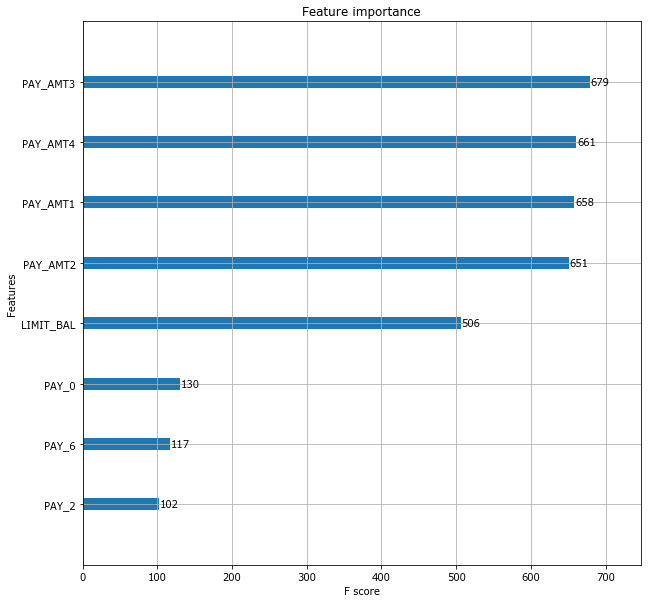

In [42]:
pylab.rcParams['figure.figsize']=(10,10)
plot_importance(xgbc)
temp_vars

In [43]:
{'learning_rate': 0.05,
 'max_depth': 3.0,
 'min_child_weight': 0,
 'n_estimators': 156,
 'subsample': 0.6150428682498997}

{'learning_rate': 0.05,
 'max_depth': 3.0,
 'min_child_weight': 0,
 'n_estimators': 156,
 'subsample': 0.6150428682498997}

In [44]:
candid = list(X_train.columns.difference(temp_vars))

candid

['AGE', 'BILL_AMT5', 'EDUCATION_woe', 'PAY_AMT5', 'PAY_AMT6']

In [45]:
lgbm = lightgbm.LGBMClassifier(learning_rate=0.05, max_depth=3, min_child_weight=0.005, n_estimators=156, subsample=0.6150428682498997)

cols = ['LIMIT_BAL',
 'PAY_0',
 'PAY_2',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4']

candid = list(X_train.columns.difference(temp_vars))
res = []
while len(candid)>0:
    temp_ginis = []
    for i in candid:
        lgbm.fit(X_train[cols+[i]], y_train)
        Proba_test = lgbm.predict_proba(X_test[cols+[i]])[:,1]
        temp_ginis.append(roc_auc_score(y_test, Proba_test)*2-1)
    best_candid = candid[np.argmax(temp_ginis)]
    best_gini = np.max(temp_ginis)
    print(best_candid, best_gini)
    res.append({'variable':best_candid, 'test_gini':best_gini})
    cols.append(best_candid)
    candid = [i for i in candid if i!=best_candid]
    #print('eto',candid)

BILL_AMT5 0.559817585134041
PAY_AMT6 0.5613741031033457
AGE 0.562974789321067
EDUCATION_woe 0.5631490887873638
PAY_AMT5 0.5613939168970277


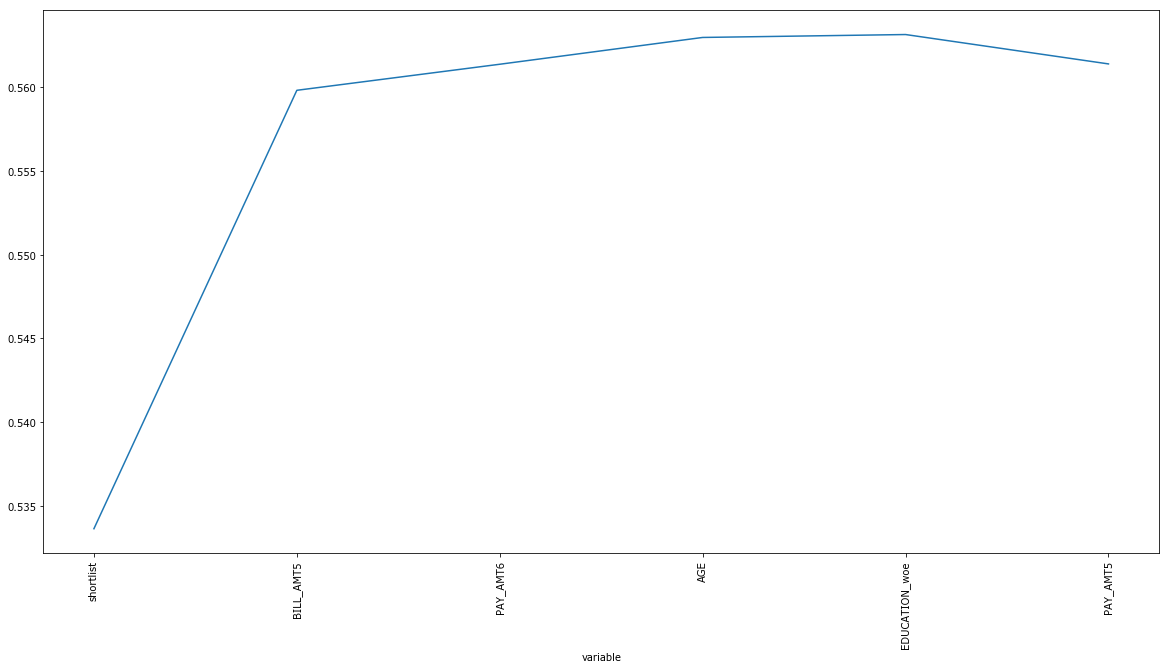

In [46]:
forw = pd.DataFrame([{'variable':'shortlist','test_gini':0.5336274649726698}]+res)
forw.index=forw.variable
forw.test_gini.plot(rot=90, figsize=(20,10), xticks=np.arange(len(forw)))

In [47]:
dat = ['LIMIT_BAL',
 'PAY_0',
 'PAY_2',
 'PAY_6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
        'BILL_AMT5',
'PAY_AMT6' ,
'AGE',
'PAY_AMT5' ,
        'EDUCATION_woe',
      'target']

In [48]:
datt = data2[dat]
dt_sdatvar = sc.var_filter(datt, y="target")

[INFO] filtering variables ...
Variable filtering on 30000 rows and 14 columns in 00:01:08 
0 variables are removed


In [49]:
list(dt_sdatvar.columns)

['PAY_0',
 'AGE',
 'PAY_AMT4',
 'PAY_AMT3',
 'PAY_6',
 'PAY_2',
 'PAY_AMT6',
 'PAY_AMT5',
 'LIMIT_BAL',
 'PAY_AMT1',
 'EDUCATION_woe',
 'BILL_AMT5',
 'PAY_AMT2',
 'target']

In [50]:
dt_sdatvar.fillna(-9999, inplace=True)

In [51]:
dt_sdatvar

,PAY_0,AGE,PAY_AMT4,PAY_AMT3,PAY_6,PAY_2,PAY_AMT6,PAY_AMT5,LIMIT_BAL,PAY_AMT1,EDUCATION_woe,BILL_AMT5,PAY_AMT2,target
0,2,24,0,0,-2,2,0,0,20000,0,0.091280,0,689,1
1,-1,26,1000,1000,2,2,2000,0,120000,0,0.091280,3455,1000,1
2,0,34,1000,1000,0,0,5000,1000,90000,1518,0.091280,14948,1500,0
3,0,37,1100,1200,0,0,1000,1069,50000,2000,0.091280,28959,2019,0
4,-1,57,9000,10000,0,0,679,689,50000,2000,0.091280,19146,36681,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,39,3047,5003,0,0,1000,5000,220000,8500,0.168328,31237,20000,0
29996,-1,43,129,8998,0,-1,0,0,150000,1837,0.168328,5190,3526,0
29997,4,37,4200,22000,0,3,3100,2000,30000,0,0.091280,20582,0,1
29998,1,41,1926,1178,-1,-1,1804,52964,80000,85900,0.168328,11855,3409,1


[INFO] creating woe binning ...
Binning on 30000 rows and 14 columns in 00:00:11
-------- 1/9 AGE --------
>>> dt[AGE].describe(): 
count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64 



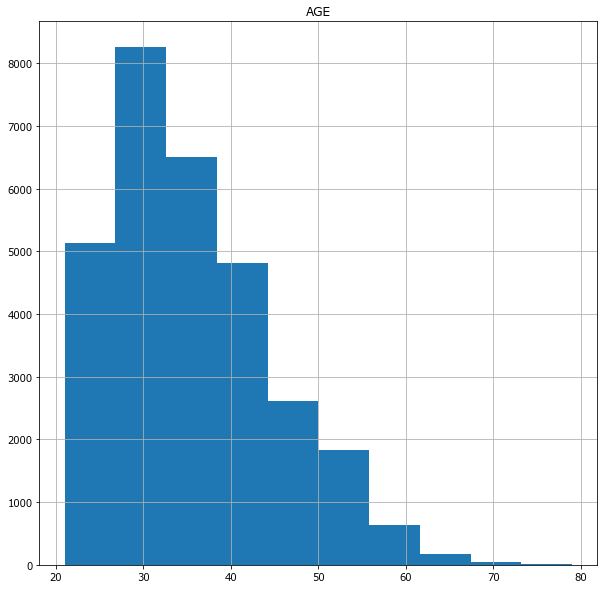

>>> Current breaks:
26.0,29.0,36.0,46.0 



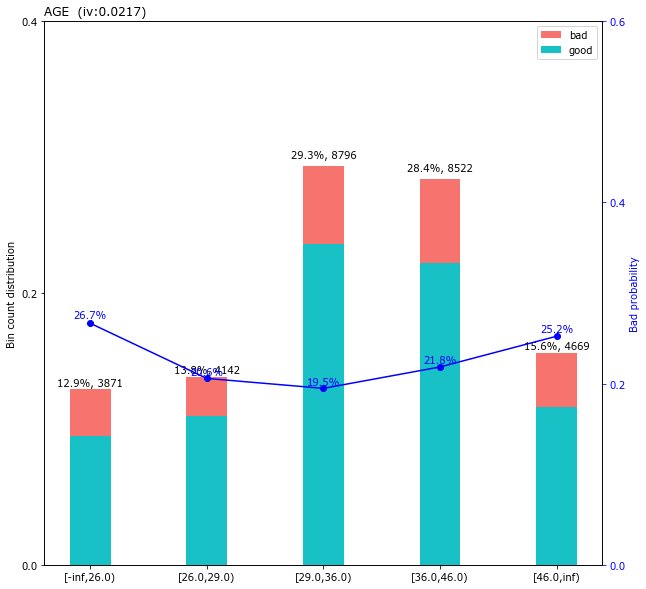

>>> Adjust breaks for (1/9) AGE?
1: next 
2: yes 
3: back


Selection:  1


-------- 2/9 BILL_AMT5 --------
>>> dt[BILL_AMT5].describe(): 
count     30000.000000
mean      40311.400967
std       60797.155770
min      -81334.000000
25%        1763.000000
50%       18104.500000
75%       50190.500000
max      927171.000000
Name: BILL_AMT5, dtype: float64 



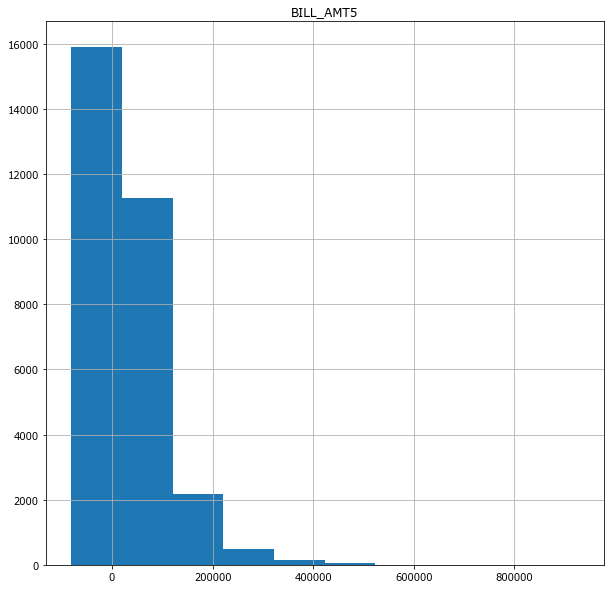

>>> Current breaks:
15000.0,50000.0,165000.0 



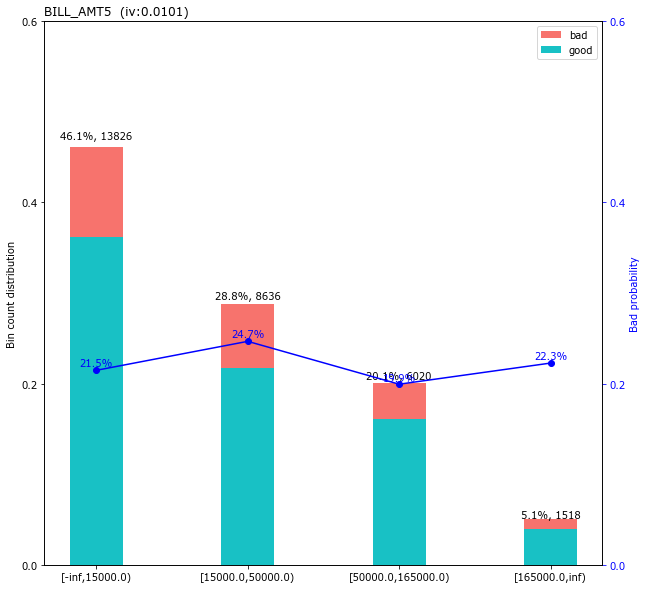

>>> Adjust breaks for (2/9) BILL_AMT5?
1: next 
2: yes 
3: back


Selection:  1


-------- 3/9 EDUCATION_woe --------
>>> dt[EDUCATION_woe].describe(): 
count    30000.000000
mean        -0.007052
std          0.159634
min         -1.485866
25%         -0.208269
50%          0.091280
75%          0.091280
max          0.168328
Name: EDUCATION_woe, dtype: float64 

>>> dt[EDUCATION_woe].value_counts(): 
 0.091280    14030
-0.208269    11039
 0.168328     4917
-1.485866       14
Name: EDUCATION_woe, dtype: int64 

>>> Current breaks:
0.09127995170064153,0.16832773040566085 



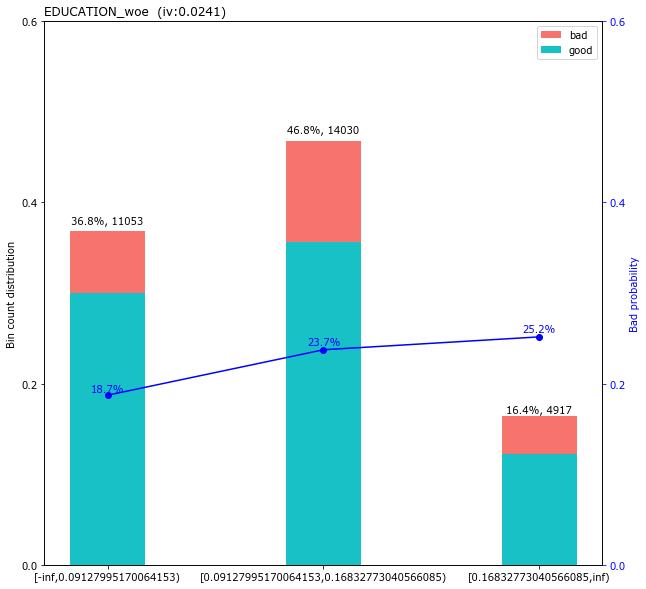

>>> Adjust breaks for (3/9) EDUCATION_woe?
1: next 
2: yes 
3: back


Selection:  1


-------- 4/9 PAY_0 --------
>>> dt[PAY_0].describe(): 
count    30000.000000
mean        -0.016700
std          1.123802
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_0, dtype: float64 



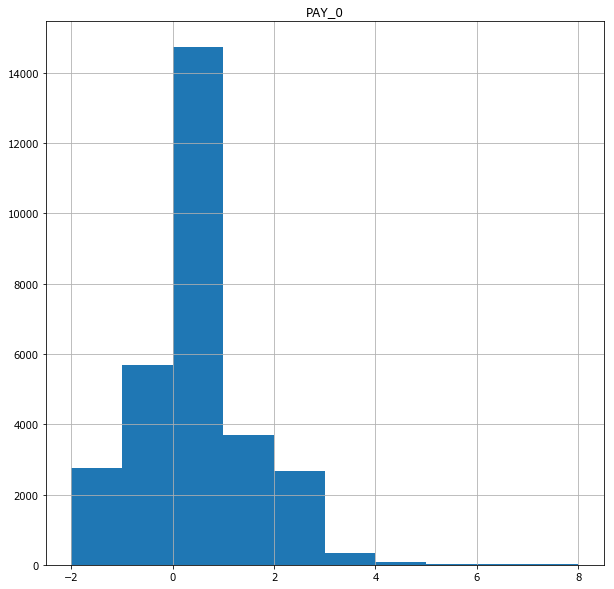

>>> Current breaks:
0.0,1.0,2.0 



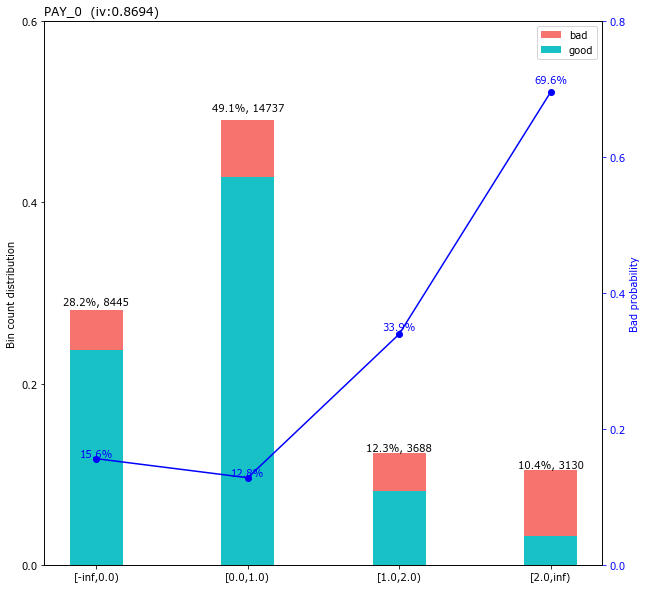

>>> Adjust breaks for (4/9) PAY_0?
1: next 
2: yes 
3: back


Selection:  1


-------- 5/9 PAY_6 --------
>>> dt[PAY_6].describe(): 
count    30000.000000
mean        -0.291100
std          1.149988
min         -2.000000
25%         -1.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: PAY_6, dtype: float64 



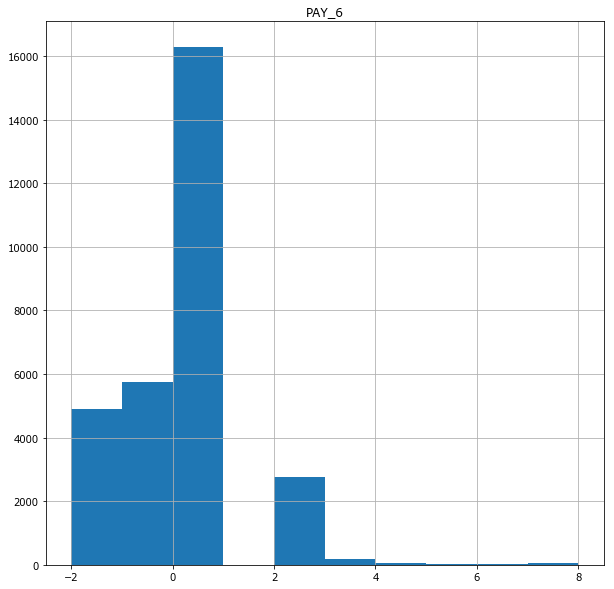

>>> Current breaks:
-1.0,2.0 



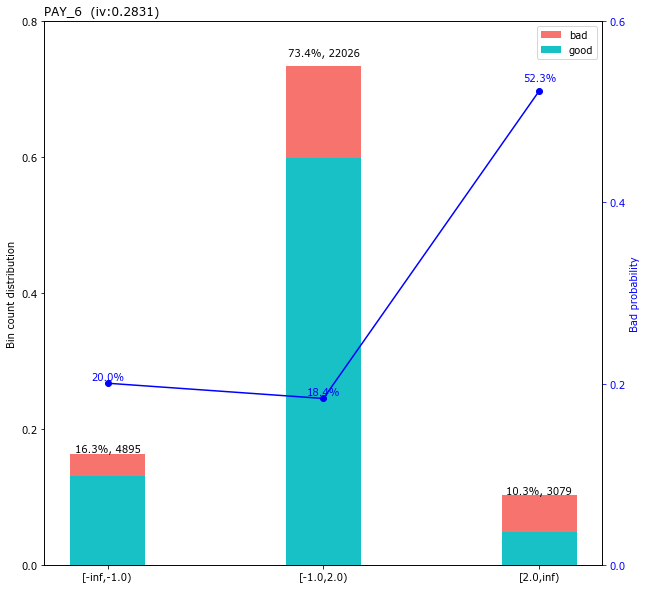

>>> Adjust breaks for (5/9) PAY_6?
1: next 
2: yes 
3: back


Selection:  1


-------- 6/9 PAY_AMT1 --------
>>> dt[PAY_AMT1].describe(): 
count     30000.000000
mean       5663.580500
std       16563.280354
min           0.000000
25%        1000.000000
50%        2100.000000
75%        5006.000000
max      873552.000000
Name: PAY_AMT1, dtype: float64 



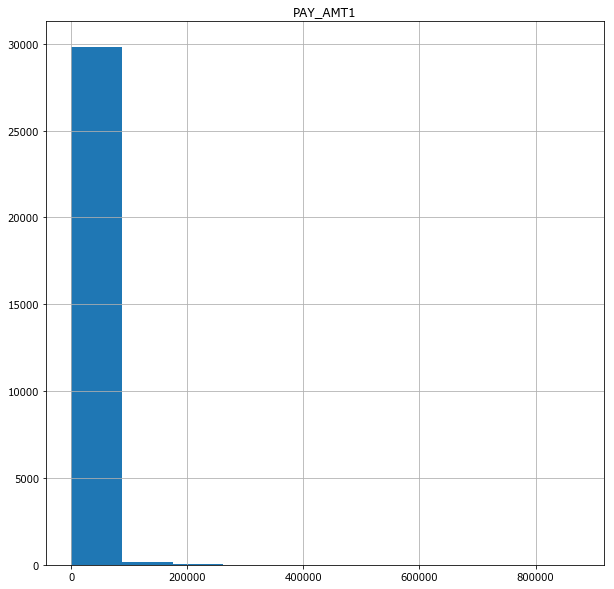

>>> Current breaks:
500.0,5000.0,17500.0 



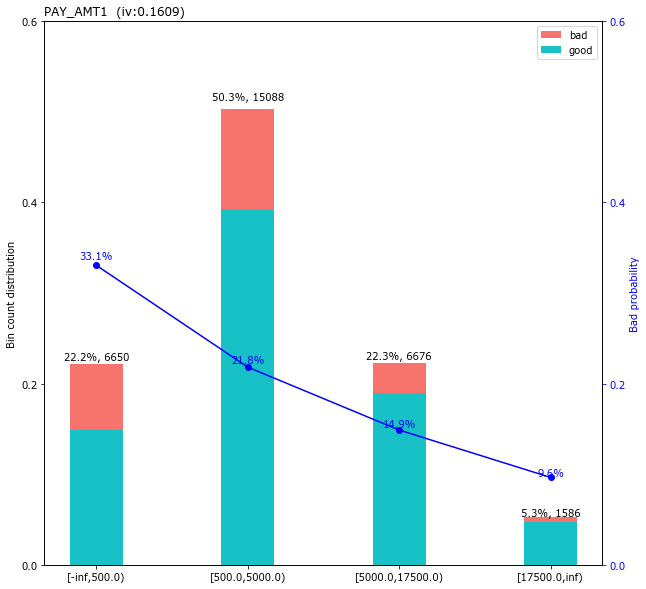

>>> Adjust breaks for (6/9) PAY_AMT1?
1: next 
2: yes 
3: back


Selection:  1


-------- 7/9 PAY_AMT3 --------
>>> dt[PAY_AMT3].describe(): 
count     30000.00000
mean       5225.68150
std       17606.96147
min           0.00000
25%         390.00000
50%        1800.00000
75%        4505.00000
max      896040.00000
Name: PAY_AMT3, dtype: float64 



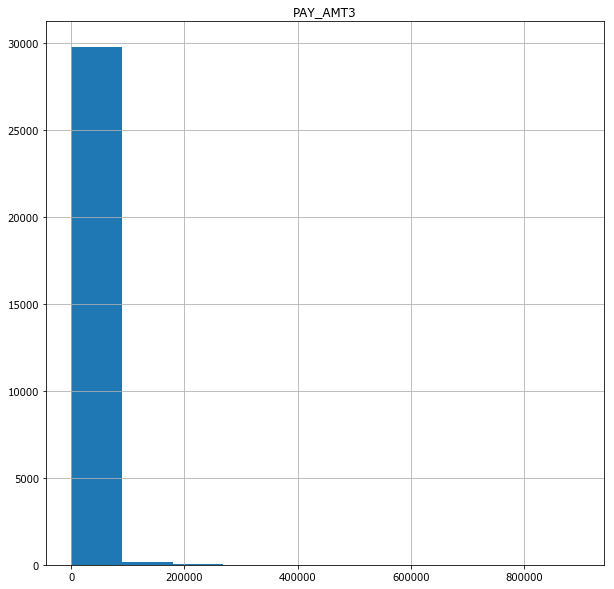

>>> Current breaks:
500.0,3000.0,5000.0,12500.0 



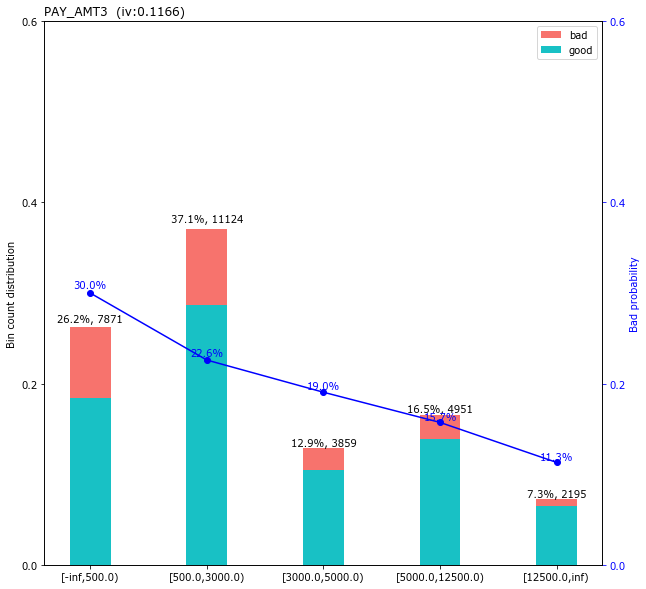

>>> Adjust breaks for (7/9) PAY_AMT3?
1: next 
2: yes 
3: back


Selection:  1


-------- 8/9 PAY_AMT4 --------
>>> dt[PAY_AMT4].describe(): 
count     30000.000000
mean       4826.076867
std       15666.159744
min           0.000000
25%         296.000000
50%        1500.000000
75%        4013.250000
max      621000.000000
Name: PAY_AMT4, dtype: float64 



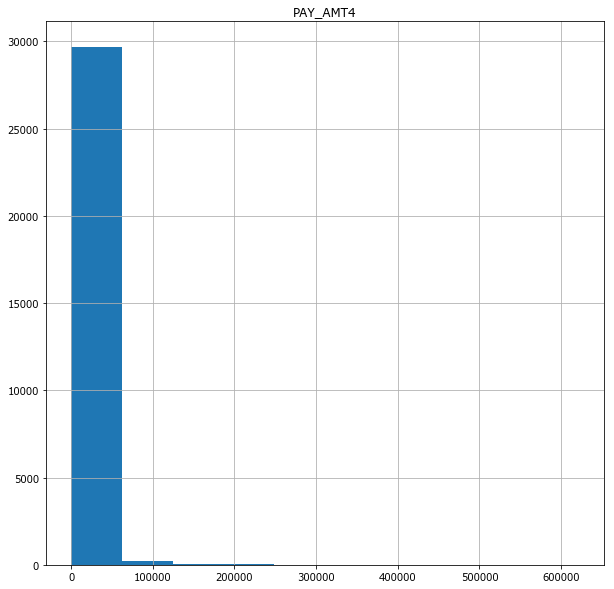

>>> Current breaks:
500.0,2000.0,4500.0,15500.0 



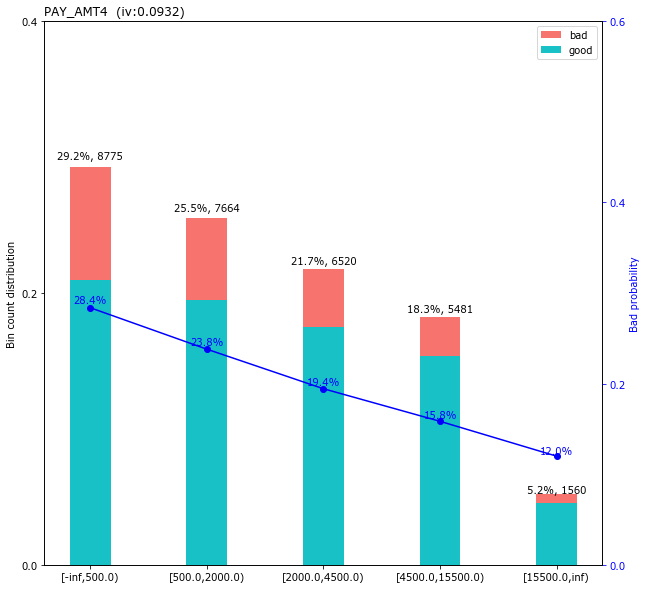

>>> Adjust breaks for (8/9) PAY_AMT4?
1: next 
2: yes 
3: back


Selection:  1


-------- 9/9 PAY_AMT6 --------
>>> dt[PAY_AMT6].describe(): 
count     30000.000000
mean       5215.502567
std       17777.465775
min           0.000000
25%         117.750000
50%        1500.000000
75%        4000.000000
max      528666.000000
Name: PAY_AMT6, dtype: float64 



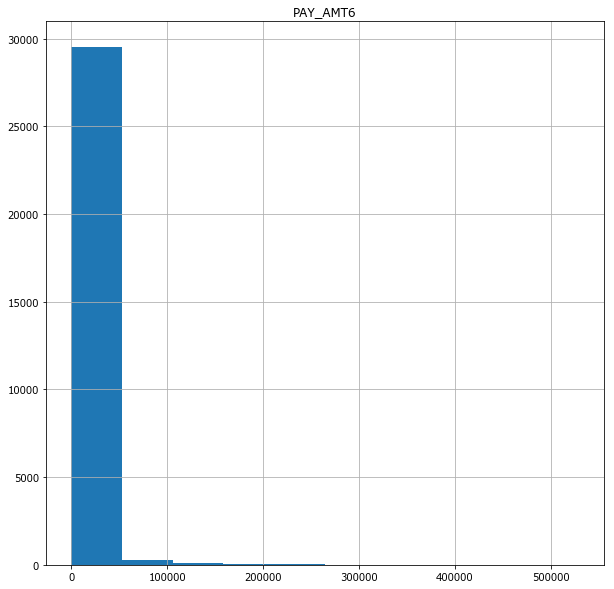

>>> Current breaks:
1000.0,3000.0,4000.0,10000.0 



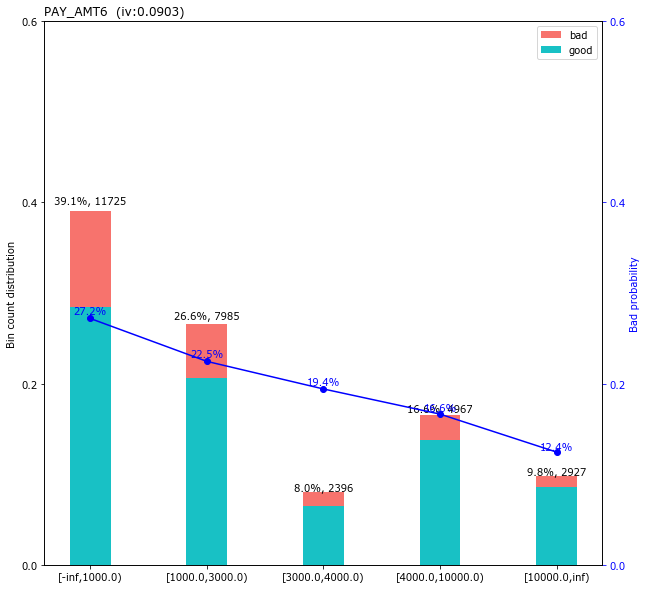

>>> Adjust breaks for (9/9) PAY_AMT6?
1: next 
2: yes 
3: back


Selection:  1


In [54]:
bins = sc.woebin(dt_sdatvar, y="target")
breaks_adj =sc.woebin_adj(dt_sdatvar, "target", bins)

In [55]:
bins_adj = sc.woebin(dt_sdatvar, y="target", breaks_list=breaks_adj)
print(breaks_adj)

[INFO] creating woe binning ...
{'AGE': [26.0,29.0,36.0,46.0], 'BILL_AMT5': [15000.0,50000.0,165000.0], 'EDUCATION_woe': [0.09127995170064153,0.16832773040566085], 'LIMIT_BAL': [40000.0,140000.0,380000.0], 'PAY_0': [0.0,1.0,2.0], 'PAY_2': [-1.0,2.0], 'PAY_6': [-1.0,2.0], 'PAY_AMT1': [500.0,5000.0,17500.0], 'PAY_AMT2': [500.0,2000.0,5000.0,17500.0], 'PAY_AMT3': [500.0,3000.0,5000.0,12500.0], 'PAY_AMT4': [500.0,2000.0,4500.0,15500.0], 'PAY_AMT5': [500.0,3000.0,4000.0,14500.0], 'PAY_AMT6': [1000.0,3000.0,4000.0,10000.0]}


In [56]:
dt_s_woe_allvar = sc.woebin_ply(dt_sdatvar, bins_adj)
dt_s_woe_allvar.head()

[INFO] converting into woe values ...


,target,AGE_woe,PAY_0_woe,PAY_AMT4_woe,PAY_AMT3_woe,PAY_6_woe,PAY_2_woe,PAY_AMT6_woe,PAY_AMT5_woe,LIMIT_BAL_woe,PAY_AMT1_woe,EDUCATION_woe_woe,BILL_AMT5_woe,PAY_AMT2_woe
0,1,0.246734,2.084775,0.332804,0.411208,-0.125056,1.501138,0.273671,0.300488,0.676765,0.552881,0.091416,-0.038327,0.072079
1,1,-0.092369,-0.428189,0.094988,0.027638,1.351641,1.501138,0.019319,0.300488,0.197458,0.552881,0.091416,-0.038327,0.072079
2,0,-0.160764,-0.659061,0.094988,0.027638,-0.233450,-0.404764,-0.353411,0.044275,0.197458,-0.017578,0.091416,-0.038327,0.072079
3,0,-0.016469,-0.659061,0.094988,0.027638,-0.233450,-0.404764,0.019319,0.044275,0.197458,-0.017578,0.091416,0.142084,-0.053113
4,0,0.172317,-0.428189,-0.411755,-0.420977,-0.233450,-0.404764,0.273671,0.044275,0.197458,-0.017578,0.091416,0.142084,-1.177714


In [57]:
bins_adj

{'AGE':   variable          bin  count  count_distr  good   bad   badprob       woe  \
 0      AGE  [-inf,26.0)   3871     0.129033  2839  1032  0.266598  0.246734   
 1      AGE  [26.0,29.0)   4142     0.138067  3290   852  0.205698 -0.092369   
 2      AGE  [29.0,36.0)   8796     0.293200  7083  1713  0.194748 -0.160764   
 3      AGE  [36.0,46.0)   8522     0.284067  6661  1861  0.218376 -0.016469   
 4      AGE   [46.0,inf)   4669     0.155633  3491  1178  0.252302  0.172317   
 
      bin_iv  total_iv breaks  is_special_values  
 0  0.008390  0.021694   26.0              False  
 1  0.001148  0.021694   29.0              False  
 2  0.007238  0.021694   36.0              False  
 3  0.000077  0.021694   46.0              False  
 4  0.004842  0.021694    inf              False  ,
 'PAY_0':   variable         bin  count  count_distr   good   bad   badprob       woe  \
 0    PAY_0  [-inf,0.0)   8445     0.281500   7126  1319  0.156187 -0.428189   
 1    PAY_0   [0.0,1.0)  14737     

In [59]:
list(dt_s_woe_allvar.columns)

['target',
 'AGE_woe',
 'PAY_0_woe',
 'PAY_AMT4_woe',
 'PAY_AMT3_woe',
 'PAY_6_woe',
 'PAY_2_woe',
 'PAY_AMT6_woe',
 'PAY_AMT5_woe',
 'LIMIT_BAL_woe',
 'PAY_AMT1_woe',
 'EDUCATION_woe_woe',
 'BILL_AMT5_woe',
 'PAY_AMT2_woe']

In [60]:
var_log = [
 'LIMIT_BAL_woe',
 'BILL_AMT5_woe',
 'PAY_AMT6_woe',
 'AGE_woe',
 'PAY_AMT5_woe',
 'PAY_AMT4_woe',
 'PAY_2_woe',
 'PAY_6_woe',
 'PAY_AMT1_woe',
 'PAY_AMT2_woe',
 'EDUCATION_woe_woe',
 'PAY_0_woe',
 'PAY_AMT3_woe']

X_log = dt_s_woe_allvar[var_log]
y_log = dt_s_woe_allvar['target']

X_train1, X_test1, y_train1, y_test1 =  train_test_split(X_log, y_log,
                                                    stratify = y,
                                                   random_state = 2,
                                                   test_size = 0.25)

print(X_train1.shape, X_test1.shape)
print(y_train1.mean(), y_test1.mean())

(22500, 13) (7500, 13)
0.2212 0.2212


In [92]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr.fit(X_train1,y_train1)

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [93]:
train_pred = lr.predict_proba(X_train1)[:,1]
test_pred = lr.predict_proba(X_test1)[:,1]

In [94]:
test_pred

array([0.1838851 , 0.12836048, 0.16665745, ..., 0.15494972, 0.12197702,
       0.50005559])

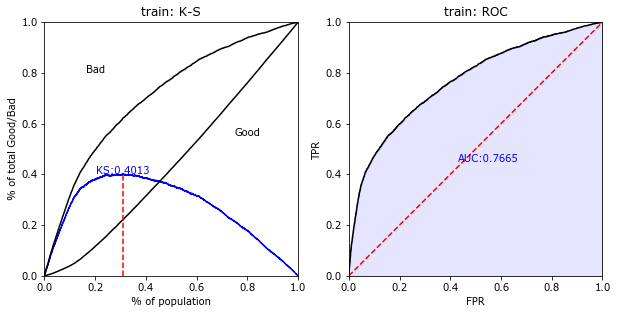

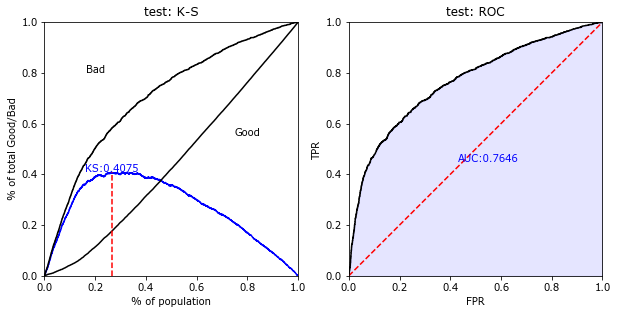

In [88]:
train_pref = sc.perf_eva(y_train1, train_pred, title = "train")
test_pref = sc.perf_eva(y_test1, test_pred, title = "test")

In [67]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [70]:
sfs = SFS(estimator=lr,
         k_features=(10,13),
         forward=True,
         floating=False,
         scoring='roc_auc',
         cv=5)
feature_names=[
 'LIMIT_BAL_woe',
 'BILL_AMT5_woe',
 'PAY_AMT6_woe',
 'AGE_woe',
 'PAY_AMT5_woe',
 'PAY_AMT4_woe',
 'PAY_2_woe',
 'PAY_6_woe',
 'PAY_AMT1_woe',
 'PAY_AMT2_woe',
 'EDUCATION_woe_woe',
 'PAY_0_woe',
 'PAY_AMT3_woe']

sfs = sfs.fit(X_train1, y_train1)

print('best combination (ACC: %.3f):%s\n' % (sfs.k_score_, sfs.k_feature_names_))
print('all subsets: \n', sfs.subsets_)
sfs.k_feature_names_

best combination (ACC: 0.766):('LIMIT_BAL_woe', 'BILL_AMT5_woe', 'AGE_woe', 'PAY_AMT5_woe', 'PAY_AMT4_woe', 'PAY_2_woe', 'PAY_6_woe', 'PAY_AMT1_woe', 'PAY_AMT2_woe', 'EDUCATION_woe_woe', 'PAY_0_woe', 'PAY_AMT3_woe')

all subsets: 
 {1: {'feature_idx': (11,), 'cv_scores': array([0.70017864, 0.69020868, 0.69827583, 0.70415953, 0.6995714 ]), 'avg_score': 0.6984788157097366, 'feature_names': ('PAY_0_woe',)}, 2: {'feature_idx': (9, 11), 'cv_scores': array([0.74129005, 0.73079033, 0.74645739, 0.74416015, 0.74324309]), 'avg_score': 0.7411882009349122, 'feature_names': ('PAY_AMT2_woe', 'PAY_0_woe')}, 3: {'feature_idx': (7, 9, 11), 'cv_scores': array([0.75207937, 0.74518799, 0.75431394, 0.75046719, 0.75189413]), 'avg_score': 0.7507885261070457, 'feature_names': ('PAY_6_woe', 'PAY_AMT2_woe', 'PAY_0_woe')}, 4: {'feature_idx': (0, 7, 9, 11), 'cv_scores': array([0.7555062 , 0.75835569, 0.75742306, 0.76052569, 0.75737382]), 'avg_score': 0.7578368928885185, 'feature_names': ('LIMIT_BAL_woe', 'PAY_6_w

('LIMIT_BAL_woe',
 'BILL_AMT5_woe',
 'AGE_woe',
 'PAY_AMT5_woe',
 'PAY_AMT4_woe',
 'PAY_2_woe',
 'PAY_6_woe',
 'PAY_AMT1_woe',
 'PAY_AMT2_woe',
 'EDUCATION_woe_woe',
 'PAY_0_woe',
 'PAY_AMT3_woe')

In [96]:

var_log2 = [
'LIMIT_BAL_woe', 
'AGE_woe', 
'PAY_AMT4_woe', 
'PAY_2_woe', 
'PAY_6_woe', 
'PAY_AMT1_woe', 
'PAY_AMT2_woe', 
'EDUCATION_woe_woe', 
'PAY_0_woe', 
'PAY_AMT3_woe']



X_log2 = dt_s_woe_allvar[var_log2]
y_log2 = dt_s_woe_allvar['target']

X_train2, X_test2, y_train2, y_test2 =  train_test_split(X_log2, y_log2,
                                                    stratify = y,
                                                   random_state = 2,
                                                   test_size = 0.25)

print(X_train2.shape, X_test2.shape)
print(y_train2.mean(), y_test2.mean())

(22500, 10) (7500, 10)
0.2212 0.2212


In [97]:
from sklearn.linear_model import LogisticRegression
lr2 = LogisticRegression(penalty='l1', C=0.9, solver='saga', n_jobs=-1)
lr2.fit(X_train2,y_train2)

LogisticRegression(C=0.9, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)

In [98]:
train_pred2 = lr2.predict_proba(X_train2)[:,1]
test_pred2 = lr2.predict_proba(X_test2)[:,1]

In [100]:
test_pref2

{'KS': 0.4091,
 'AUC': 0.7645,
 'Gini': 0.529,
 'pic': <Figure size 720x720 with 2 Axes>}

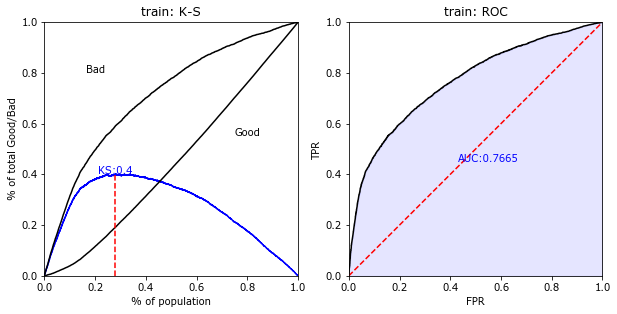

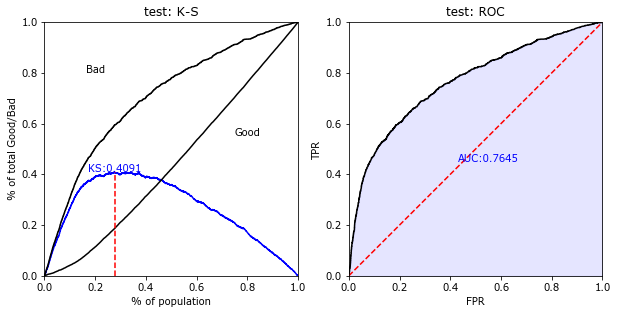

In [99]:
train_pref2 = sc.perf_eva(y_train2, train_pred2, title = "train")
test_pref2 = sc.perf_eva(y_test2, test_pred2, title = "test")

In [81]:
card = sc.scorecard(bins_adj, lr2, X_train2.columns, odds0=0.5, pdo=20, basepoints_eq0=600)

In [82]:
card

{'basepoints':      variable  bin  points
 0  basepoints  NaN       0,
 'LIMIT_BAL':     variable                  bin  points
 0  LIMIT_BAL       [-inf,40000.0)    55.0
 1  LIMIT_BAL   [40000.0,140000.0)    60.0
 2  LIMIT_BAL  [140000.0,380000.0)    65.0
 3  LIMIT_BAL       [380000.0,inf)    69.0,
 'AGE':    variable          bin  points
 13      AGE  [-inf,26.0)    59.0
 14      AGE  [26.0,29.0)    62.0
 15      AGE  [29.0,36.0)    63.0
 16      AGE   [36.0,inf)    61.0,
 'PAY_AMT4':     variable               bin  points
 22  PAY_AMT4      [-inf,500.0)    59.0
 23  PAY_AMT4    [500.0,2000.0)    61.0
 24  PAY_AMT4   [2000.0,4500.0)    63.0
 25  PAY_AMT4  [4500.0,15500.0)    65.0
 26  PAY_AMT4     [15500.0,inf)    67.0,
 'PAY_2':    variable         bin  points
 27    PAY_2  [-inf,2.0)    63.0
 28    PAY_2   [2.0,inf)    55.0,
 'PAY_6':    variable         bin  points
 29    PAY_6  [-inf,2.0)    64.0
 30    PAY_6   [2.0,inf)    44.0,
 'PAY_AMT1':     variable               bin  points

In [83]:
import csv

with open(r'card.csv', 'w') as f:
    for key in card.keys():
        f.write("%s, %s\n"%(key, card[key]))